In [ ]:
pip install circe

In [31]:

pip install ..

Processing /home/rtrimbou/circe/circe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circe: filename=circe-0.1.6-cp310-cp310-manylinux_2_35_x86_64.whl size=239710 sha256=27130009bfec4bb4427c3f71afe869a9b7177df033333e5101bbd7be69d225b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmthx02m/wheels/00/f4/bb/b1e7aa54ec6f138ef0b5c7db3d0adeba72c18ca844efc143dc
Successfully built circe
  Attempting uninstall: circe
    Found existing installation: circe 0.1.6
    Uninstalling circe-0.1.6:
      Successfully uninstalled circe-0.1.6
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install snapatac2

In [ ]:
pip install ipywidgets

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*Reordering categories will always return a new Categorical object.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*is_categorical_dtype is deprecated and will be removed in a future version.*")

In [2]:
import circe as ci
import circe.metacells as circe_metacells
import circe.draw
import scanpy as sc

In [3]:
import numpy as np
import pandas as pd
import anndata as ad

import scipy as sp
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

# Test with sparse covariance true matrix as GT

### 0. Create fake AnnData

In [4]:
# Create fake single-cell atac-seq data
nb_cells = 300
nb_chr = 10
nb_regions_per_chr = 200
between_reg = 2000
size_reg = 50

counts = []
for chr in range(nb_chr):
    counts.append(pd.DataFrame(np.random.randint(0,100, size=(nb_cells, nb_regions_per_chr)),
                        index=['Cell_'+j for j in map(str, range(nb_cells))],
                        columns=['chr'+str(chr)+'_'+str(i)+'_'+str(i+size_reg) for i in range(1, nb_regions_per_chr*between_reg+1, between_reg)]))
atac = ad.AnnData(pd.concat(counts, axis=1))

In [5]:
distance_threshold = 50000

### 1. Add region position in AnnData.obs

In [6]:
atac = ci.add_region_infos(atac)

### 2. Replace random data with fake cov matrix

In [7]:
n_samples, n_features = 300, nb_regions_per_chr

prng = np.random.RandomState(0)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.99, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)

#cov with only potential connections
possible_co = sp.sparse.csr_matrix(ci.circe.get_distances_regions(atac)<distance_threshold/2)[:cov.shape[0],:cov.shape[1]]
possible_co = sp.sparse.coo_matrix(possible_co).toarray() + sp.sparse.coo_matrix(possible_co).toarray().T 
cov = np.eye(len(cov))*np.diag(cov) + possible_co*cov 
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

X_ = np.concatenate([X]*nb_chr, axis=1)
atac.X = np.abs(X_)
atac.X = np.where(X_<0, 0, X_)

### 2.A. Remove Null rows

In [8]:
sc.pp.filter_genes(atac, min_cells=1)
atac

/home/rtrimbou/miniconda3/envs/hummuspy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


AnnData object with n_obs × n_vars = 300 × 2000
    var: 'chromosome', 'start', 'end', 'n_cells'

### 2.B. Compute pseudocells

In [9]:
metacells = circe_metacells.compute_metacells(atac)

Output()

### 3 Calculate co-accessibility

In [10]:
ci.compute_atac_network(
    atac, #metacells,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60
)

Output()

Output()

Alpha coefficient calculated : 0.02528988006989373
Starting to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


Output()

Finishing to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


50000 50000
Averaging co-accessibility scores across windows...
50000 50000
95190
69190
[ 1.00000000e+00 -1.24392692e-02  9.93993313e-04 ... -7.77882879e-02
 -1.11110192e-03  2.00000000e+00]
[ 1.00000000e+00 -1.24392692e-02  9.93993313e-04 ... -3.88941439e-02
 -5.55550961e-04  1.00000000e+00]
Done !


*Can be stored externally using sliding_graphica_lasso*

In [11]:
atac.X = sp.sparse.csr_matrix(atac.X)
# atac.X = atac.X.toarray()

In [12]:
final_score = ci.sliding_graphical_lasso(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500
)
atac.varp['atac_network'] = final_score

Output()

Output()

Alpha coefficient calculated : 0.025271811863242673
Starting to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


Output()

Finishing to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


50000 50000
Averaging co-accessibility scores across windows...
50000 50000
95190
69190
[ 1.00000000e+00 -1.24721775e-02  9.98813486e-04 ... -7.79365908e-02
 -1.11586689e-03  2.00000000e+00]
[ 1.00000000e+00 -1.24721775e-02  9.98813486e-04 ... -3.89682954e-02
 -5.57933444e-04  1.00000000e+00]
Done !


### 3. B. Extract list of edges

In [13]:
circe_network = ci.extract_atac_links(atac) #metacells)
circe_network

,Peak1,Peak2,score
6499,chr2_214001_214051,chr2_228001_228051,0.211159
23992,chr9_214001_214051,chr9_228001_228051,0.211159
13996,chr5_214001_214051,chr5_228001_228051,0.211159
16495,chr6_214001_214051,chr6_228001_228051,0.211159
8998,chr3_214001_214051,chr3_228001_228051,0.211159
...,...,...,...
8302,chr3_102001_102051,chr3_104001_104051,-0.074203
5803,chr2_102001_102051,chr2_104001_104051,-0.074203
805,chr0_102001_102051,chr0_104001_104051,-0.074203
23296,chr9_102001_102051,chr9_104001_104051,-0.074203


### 4. Plot co-accessibility scores in a window

0.19018547483172216


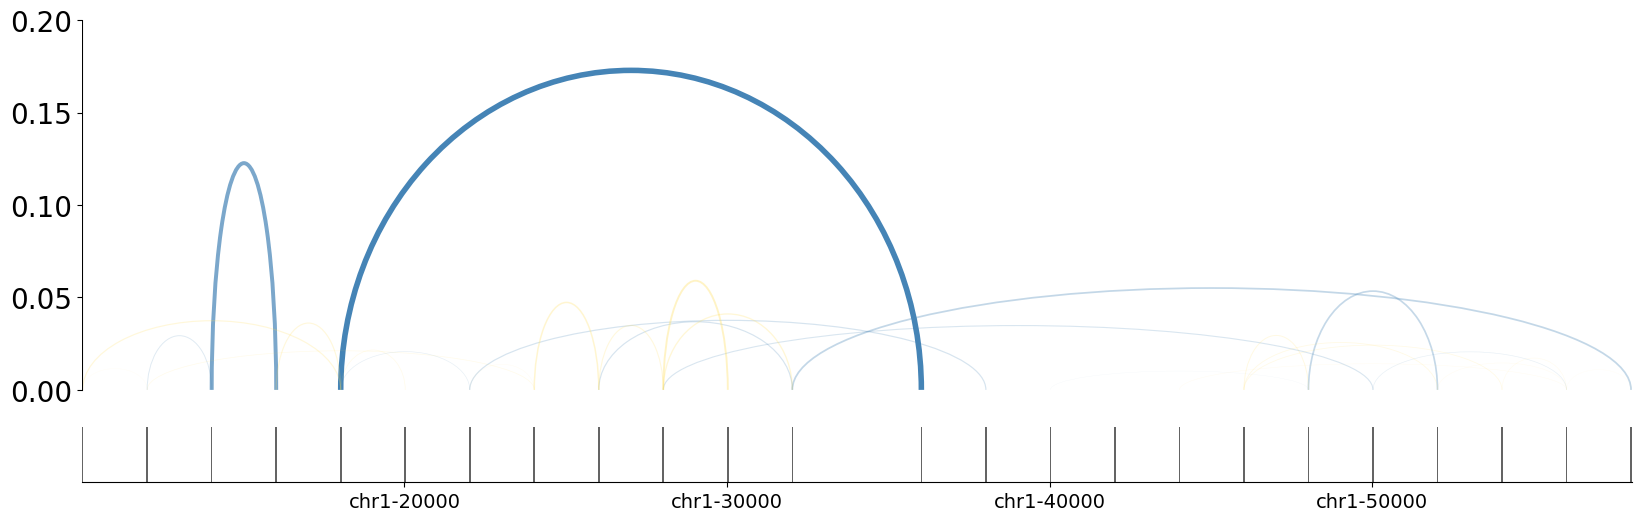

In [17]:
circe.draw.plot_connections(
    circe_network,
    chromosome="chr1",
    start=10000,
    end=60000,
    sep=("_","_"),
    abs_threshold=0.01
)